Enter time range in format (e.g., 7:00 AM to 8:00 AM): 7:00 AM to 8:00 PM


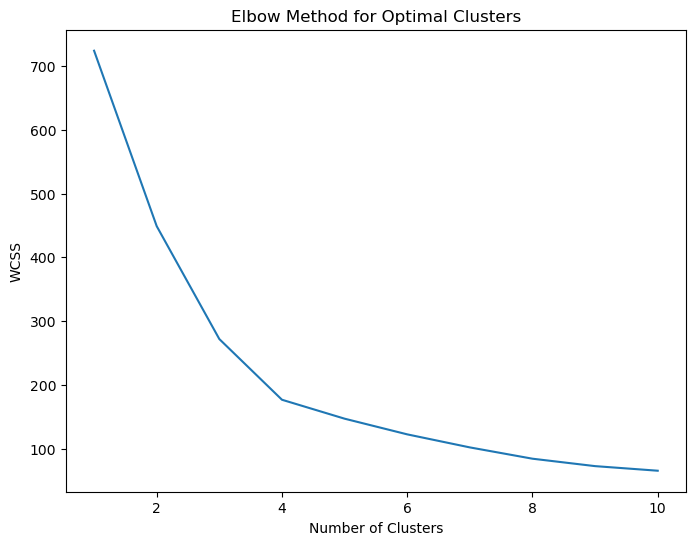

Based on the Elbow graph, enter the optimal number of clusters: 4

Silhouette Score for the chosen number of clusters (4): 0.414
Interpretation:
The Silhouette Score is 0.414, which indicates **moderate clustering quality**. Clusters exist but may have significant overlap or unclear boundaries.


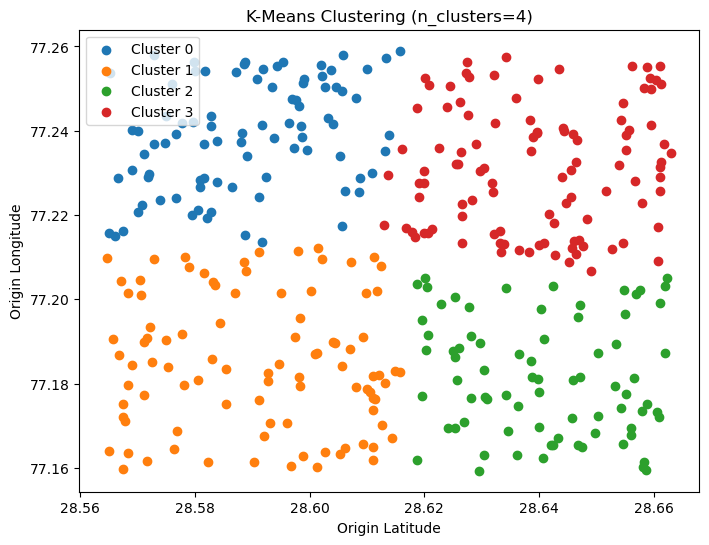


Summary of trips in the given time range (7:00 AM to 8:00 PM):
- Total trips: 362

Number of trips in each cluster:
  Cluster 3: 104 trips
  Cluster 1: 94 trips
  Cluster 0: 87 trips
  Cluster 2: 77 trips

Dominant Cluster: Cluster 3
- Geographical area of dominant cluster:
  Latitude range: (28.61294, 28.663009)
  Longitude range: (77.206715, 77.257464)

Trip Purpose Analysis:
- Trip Purposes and their counts:
Trip Purpose
Random Place        42
Shopping Areas      35
City Exploration    29
Market              26
City Mall           24
School to Home      24
Gardens             23
Cafes               23
Parks               23
Office Drop         22
Temple              21
Zoo                 19
Restaurants         18
School Drop         17
Office to Home      16
- Most frequent trip purpose: Random Place
- Most cabs are used for: Random Place trips.


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def convert_to_24hr(time_str):
    return pd.to_datetime(time_str, format='%I:%M %p').time()

def filter_trips_by_time_range(start_time, end_time, data):
    data['Time_24hr'] = data['Time'].apply(lambda x: convert_to_24hr(x))
    start_time_24hr = pd.to_datetime(start_time, format='%I:%M %p').time()
    end_time_24hr = pd.to_datetime(end_time, format='%I:%M %p').time()
    return data[(data['Time_24hr'] >= start_time_24hr) & (data['Time_24hr'] <= end_time_24hr)].copy()

def interpret_silhouette_score(score):
    print("Interpretation:")
    if score < 0:
        print(f"The Silhouette Score is {score:.3f}, which indicates **poor clustering performance**. "
              "Many samples may be assigned to the wrong clusters, or the clusters significantly overlap.")
    elif 0 <= score <= 0.5:
        print(f"The Silhouette Score is {score:.3f}, which indicates **moderate clustering quality**. "
              "Clusters exist but may have significant overlap or unclear boundaries.")
    elif 0.5 < score <= 1:
        print(f"The Silhouette Score is {score:.3f}, which indicates **good clustering performance**. "
              "Clusters are well-defined, and most samples are appropriately grouped.")
    else:
        print(f"The Silhouette Score is {score:.3f}. This value is unexpected and may indicate an error in the calculation.")

trip_data = pd.read_csv("C:\\Users\\sogim\\OLA CLUSTERING\\ola_trip_data.csv")

time_range_input = input("Enter time range in format (e.g., 7:00 AM to 8:00 AM): ")
start_time, end_time = time_range_input.split(" to ")

filtered_data = filter_trips_by_time_range(start_time, end_time, trip_data)

if not filtered_data.empty:
    X = filtered_data[['Origin Latitude', 'Origin Longitude']]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    optimal_clusters = int(input("Based on the Elbow graph, enter the optimal number of clusters: "))

    kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
    filtered_data['Cluster'] = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, filtered_data['Cluster'])
    print(f"\nSilhouette Score for the chosen number of clusters ({optimal_clusters}): {silhouette_avg:.3f}")
    interpret_silhouette_score(silhouette_avg)

    cluster_counts = filtered_data['Cluster'].value_counts()

    dominant_cluster = cluster_counts.idxmax()
    dominant_cluster_data = filtered_data[filtered_data['Cluster'] == dominant_cluster]
    lat_range = (dominant_cluster_data['Origin Latitude'].min(), dominant_cluster_data['Origin Latitude'].max())
    lon_range = (dominant_cluster_data['Origin Longitude'].min(), dominant_cluster_data['Origin Longitude'].max())

    trip_purposes = filtered_data['Trip Purpose'].value_counts()
    dominant_trip_purpose = trip_purposes.idxmax()

    plt.figure(figsize=(8, 6))
    for cluster in range(optimal_clusters):
        cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
        plt.scatter(cluster_data['Origin Latitude'], cluster_data['Origin Longitude'], label=f'Cluster {cluster}')
    plt.title(f"K-Means Clustering (n_clusters={optimal_clusters})")
    plt.xlabel('Origin Latitude')
    plt.ylabel('Origin Longitude')
    plt.legend()
    plt.show()

    print(f"\nSummary of trips in the given time range ({start_time} to {end_time}):")
    print(f"- Total trips: {len(filtered_data)}")
    print("\nNumber of trips in each cluster:")
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} trips")
    print(f"\nDominant Cluster: Cluster {dominant_cluster}")
    print(f"- Geographical area of dominant cluster:")
    print(f"  Latitude range: {lat_range}")
    print(f"  Longitude range: {lon_range}")
    print("\nTrip Purpose Analysis:")
    print(f"- Trip Purposes and their counts:\n{trip_purposes.to_string()}")
    print(f"- Most frequent trip purpose: {dominant_trip_purpose}")
    print(f"- Most cabs are used for: {dominant_trip_purpose} trips.")

else:
    print("No trips found in the specified time range.")